In [ ]:
# import

In [5]:
import pymisca.util as pyutil
# pyutil.d_hellinger??
# import pymisca.optim as pyopt
# pyopt
import scipy.optimize as spopt


In [6]:
# def sumNorm(r)


In [159]:
d = 10
N = 200
def randMat(d,N=N):
    res = np.random.random(size=(N,d))
    res = arr__rowNorm(res)
    return res
dx = 8
dy = 4
X = randMat(dx)
Y = randMat(dy)
# print distance__hellinger(X,Y)

size = dx,dy

def loss(S):
    S = proj(S)
    loss = distance__hellinger(Y,X.dot(S))
    return loss

In [25]:
import scipy.optimize
lst = []
def worker(i,size=size):
    dx,dy=size
    S0 = randMat(N=dx,d=dy).ravel()
    res = scipy.optimize.minimize(loss,x0=S0)
    res.s = proj(res.x)
    print res.fun
    return res
def proj(S):
    S = abs(S)
    S = S.reshape((dx,dy))
    S = arr__rowNorm(S)
    return S
    
# for i in range(1):
#     lst += [res]

In [141]:
lst = map(pyutil.functools.partial(worker,size=size),range(10))

0.0011386786619138143
0.0011360426273546963
0.0011404539671568965
0.001137725717560064
0.0011449828733996043
0.0011410350241015733
0.001134878448087198
0.0011480313694529638
0.0011434474266728966
0.0011387968811827718


In [167]:
dx = 10
dy = 10
X = randMat(dx)
# Y = randMat(dy)
ind = np.random.permutation(dx)
Y = X[:,ind]
# np.random.shuffle(Y,)
# print distance__hellinger(X,Y)

size = dx,dy
res = worker(1,size=size)

2.55341943088e-08


In [11]:
import pymisca.vis_util as pyvis

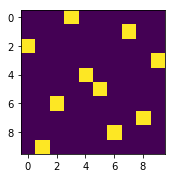

In [168]:
pyvis.heatmap(res.s,cmap=cmap)

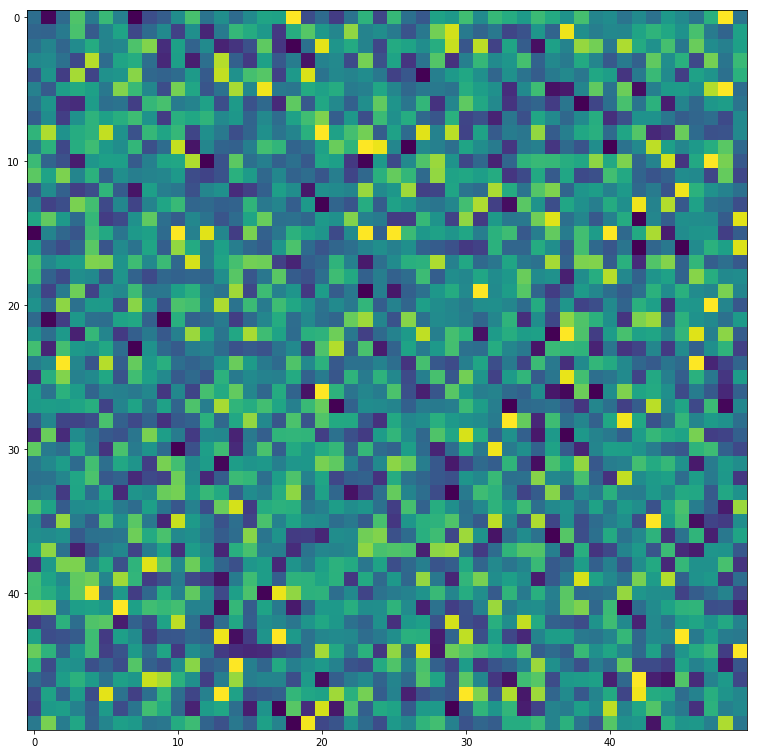

In [152]:
SD = arr.std(axis=0)
M = arr.mean(axis=0)
pyvis.heatmap(SD/M,cmap=cmap)

In [143]:
arr = np.stack([res.s for res in lst])

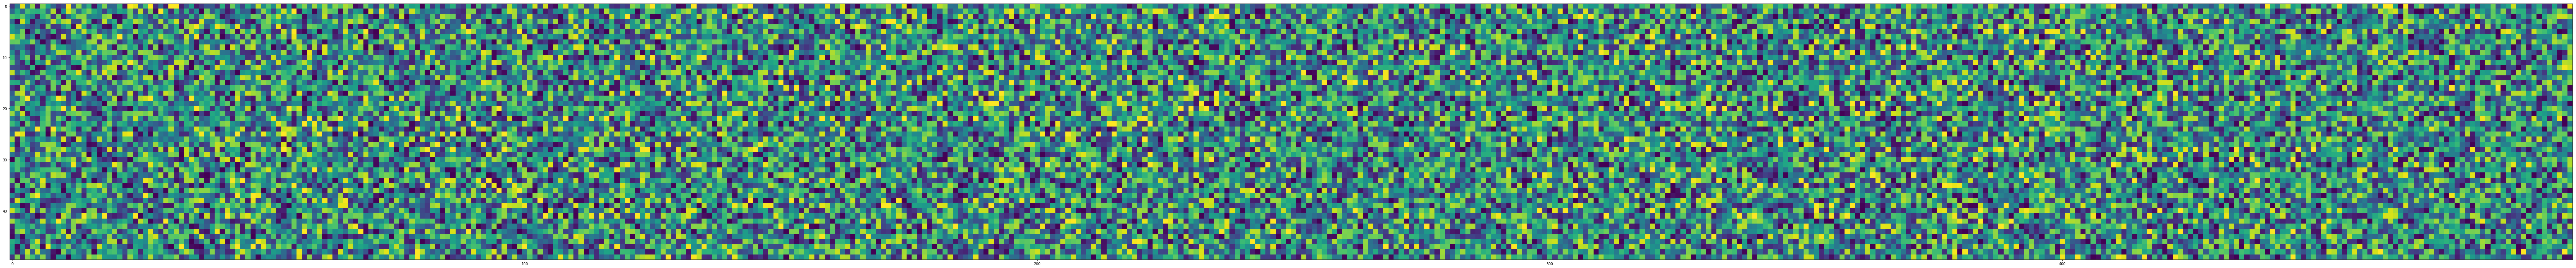

In [153]:
rr = np.hstack([res.s for res in lst])
pyvis.heatmap(rr,cmap=cmap)

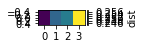

In [31]:
%matplotlib inline
cmap = pyvis.plt.get_cmap('viridis')
s = proj(res.x)
pyvis.heatmap(s,cmap=cmap,cname='dist')

$\partial$

step	0	loss	5.344E-03
step	10	loss	5.206E-03
step	20	loss	5.133E-03
step	30	loss	5.096E-03
[STOP]Speed converged:9.91E-05
0.00504541531027
0.00504541531027


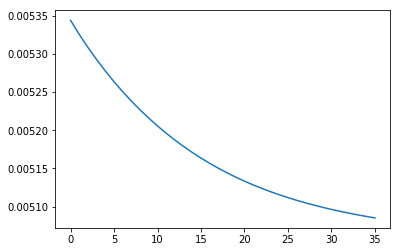

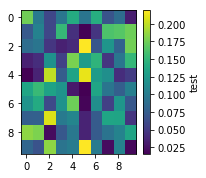

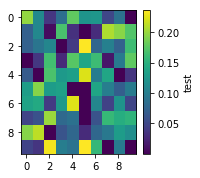

In [260]:
# import pymisca.distances as pydist
import pymisca.numpy_extra as pynp

import numpy as np
def arr__l2norm(X,axis=None,keepdims=1):
    return np.sqrt((X**2).mean(axis=axis,keepdims=keepdims))
def arr__sumNorm(X,axis=None,keepdims=1):
    SUM = (X.sum(axis=axis,keepdims=keepdims)) 
    SUM[SUM==0.]= 1.
    X = X /SUM
    return X
def arr__rowNorm(X,axis=1):
    X  = arr__sumNorm(X,axis=axis)
    return X
def arr__colNorm(X,axis=0):
    X  = arr__sumNorm(X,axis=axis)
    return X

def distance__hellinger(resp1,resp2,check = True):
    if check:
        resp1 =  arr__rowNorm(resp1,axis=1)
        resp2 =  arr__rowNorm(resp2,axis=1)
    return 0.5 * np.mean((np.sqrt(resp1) - np.sqrt(resp2))**2)
def randMat(d,N=N):
    res = np.random.random(size=(N,d))
    res = pynp.arr__rowNorm(res)
    return res    

def fitResponse(X,Y,S0=None,verbose=0,print_interval=1,
               speedTol = 1E-4,maxIter =200,
                eps=1E-10
               ):
    '''
    Author: Feng Geng
    X: numpy.ndarray (i,j)
    Y: numpy.ndarray (i,k)
    S0: numpy.ndarray (j,k)
    
    Minimise the hellinger distance between Y and X \cdot S
    non-negative matrices x_{ij}, y_{ik}, s_{jk} with constraints
    \sum_j x_{ij} = 1
    \sum_k y_{ik} = 1
    \sum_k s_{jk} = 1 
    minimise  E = - \sum_{i,k} \sqrt{ \sum_j x_{ij} y_{ik} s_{jk} } 
    by iteratively setting 
    \sqrt{ s_{jk} } = d E / d \sqrt{ s_{jk} }
    in a normalised fashion
    '''
    dx = X.shape[1]
    dy = Y.shape[1]
    
    
    def step(S):
        R = np.sqrt(S)
        C = X.dot(S)
        A = np.sqrt(Y/(C + eps) )
        grad = X.T.dot(A) * R
    #     grad = X.T.dot(A)
        S = pynp.arr__rowNorm(grad**2)
    #     S = proj(grad**2)
        return S
    

    # dx,dy=size
    if S0 is None:
        S0 = np.random.random(size=(dx,dy))
#         S0 = randMat(N=dx,d=dy)
    S0 = pynp.arr__rowNorm(S0)
        
    hist = {}
    hist['speed'] = []
    hist['loss'] = []
    S = S0
    for i in range(maxIter):
        Snew = step(S)
        speed = len(S)-np.sqrt(Snew*S).sum()
        S = Snew 
        
        ll = pynp.distance__hellinger(Y,X.dot(S))
#         ll = loss(S)
        if verbose:
            if not i % print_interval:
                print ('step\t{i}\tloss\t{ll:.3E}'.format(**locals()))
        if i>0:
#             speed= abs(ll - lst[-1])
            if speed<=speedTol:
                print ('[STOP]Speed converged:%.2E' %speed)
                break            
            if i + 1== maxIter:
                print ('[STOP]Failed to converge')
#         lst += [ll]
        hist['loss'].append(ll)
        hist['speed'].append(speed)
    res = pyutil.util_obj(**dict(
        hist=hist,
        last=S,
    ))
    return res

pynp.arr__rowNorm=arr__rowNorm
pynp.distance__hellinger = distance__hellinger
dx =dy =10

X = np.random.random(size=(N,dx,))
X = pynp.arr__rowNorm(X)
Y = np.random.random(size=(N,dy,))
Y = pynp.arr__rowNorm(Y)



res1 = res = fitResponse(X,Y,verbose=1,print_interval=10)
pyvis.plt.plot(res.hist['loss'])
pyvis.heatmap(res.last,cmap=cmap,cname='test')

res = worker(0,size=(dx,dy))
    
pyvis.heatmap(res.s,cmap=cmap,cname='test')
print res.fun
    

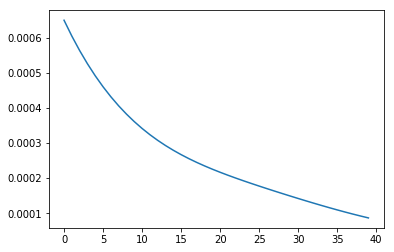

In [251]:
pyvis.plt.plot(res1.hist['speed'][10:])

-1.0195290140185484e-05


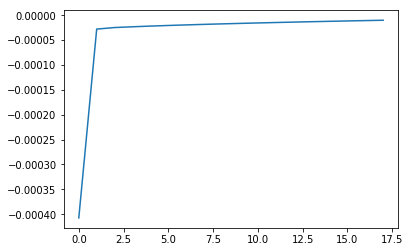

In [244]:
speed = np.diff(res1.hist)
print speed[-1
           ]

pyvis.plt.plot(speed)

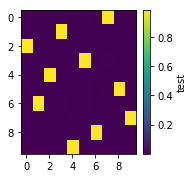

In [243]:
pyvis.heatmap(S,cmap=cmap,cname='test')

2.88670208048e-08
2.8867020804791304e-08
0.0047154378923293
0.005230905268576723


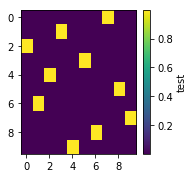

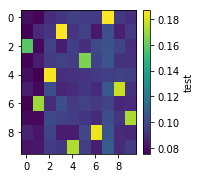

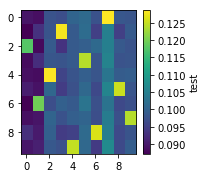

In [171]:
# dx = 14
# dy = 4
# X = randMat(dx) ** 2
# Y = randMat(dy) ** 0.5
# X = arr__rowNorm(X)
# Y = arr__rowNorm(Y)

dx =dy =10
X = randMat(dx)
# Y = randMat(dy)
ind = np.random.permutation(dx)
Y = X[:,ind]


size = dx,dy
res = worker(1,size=size)

# joint = X.T.dot(Y)
# joint = np.sqrt(arr__rowNorm(X)).T.dot(np.sqrt(arr__colNorm(Y)))
xx = X
# xx = np.sqrt(xx)
xx = arr__colNorm(xx)

yy = (np.sqrt(Y))
yy = Y
joint = xx.T.dot(yy) 
joint = joint** 2
cond = arr__rowNorm(joint)
arr1 = cond


xx = X
# xx = arr__colNorm(xx)
xx = np.sqrt(xx)

yy = (np.sqrt(Y))
joint = xx.T.dot(yy) 
joint = joint** 2
cond = arr__rowNorm(joint)
arr2 = cond


# pyvis.heatmap(res.s,cmap=cmap,cname='test')

# # pyvis.heatmap(joint,cmap=cmap,cname='test')

# # cond = arr__rowNorm(joint)
# # cond = proj(joint)
# pyvis.heatmap(cond,cmap=cmap,cname='test')


# print pyutil.mat2str(np.round(res.s,decimals=3),)
# print 
# print pyutil.mat2str(np.round(cond,decimals=3),)

for arr in [res.s,arr1,arr2]:
    print loss(arr)
    pyvis.heatmap( arr,cmap=cmap,cname='test')
# print loss(res.s)
# print loss(cond)


In [109]:
res.s.sum(axis=1), cond.sum(axis=1)

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [63]:
# res.s.sum(axis=1)
# arr__rowNorm?

In [ ]:
distance__hellinger(X,Y)
